In [1]:
from zlib import crc32
import numpy as np

if __name__=='__main__':
    mail = input('Enter phystech e-mail\n') 
    seed = crc32(mail.strip().encode('utf-8'))%(2**32 - 1)
    rs = np.random.RandomState(seed)
    print('Your tasks are:')
    print(
        '1.{}, 2.{}, 3.{}, 4.{}'.format(
            rs.randint(low=1, high=4), 
            rs.randint(low=1, high=3), 
            rs.randint(low=1, high=3), 
            rs.randint(low=1, high=3)))

Enter phystech e-mail
kuznetsov.a@phystech.edu
Your tasks are:
1.3, 2.1, 3.1, 4.2


# Задание 1.3


Проанализировать консервативность z-критерия для корреляции Пирсона в зависимости от:

* Мощности выборки
* Проверяемого значения коэффициента корреляции

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from scipy.stats.distributions import norm
from functools import reduce
from tqdm.notebook import tqdm

Будем сэмплировать из нормального распределения $N(0, \sigma)$. Тогда коэффициент корреляции Пирсона будет равен $\frac{1}{\sqrt{1+\sigma^{2}}}$.

In [2]:
# преобразование Фишера для коэффициента корреляции Пирсона
def Fischer_transform_pval(r, corr, len):
    zstat = np.arctanh(r) - np.arctanh(corr)
    zstat /= np.sqrt(len - 3)
    return 2 * (1 - norm.cdf(np.abs(zstat)))

def single_test(sample_size, sigma, alpha, corr):
    # получаем нормальные выборки
    sample_1 = np.random.randn(sample_size)
    sample_2 = sample_1 + sample_1 * sigma
    r = pearsonr(sample_1, sample_2)[0]
    return int(Fischer_transform_pval(r, corr, sample_size) <= alpha)

# берем уровень значимости apha=0.05
def test(count, sample_size, sigma, alpha=0.05):
    corr = 1 / np.sqrt(1 + sigma ** 2)
    result_z = reduce(lambda a, x: a + single_test(sample_size, sigma, alpha, corr), range(count))
    return result_z / count

1) Исследуем зависимость консервативности z-критерия для корреляции Пирсона от мощности (размера) выборки.

In [3]:
# будем сэмплировать из N(0, 1)
sigma = 1
sample_size = 500

result = []
size = np.linspace(100, 10000, 100, dtype=int)
for m in tqdm(size):
    result.append(test(m, sample_size, sigma))

  0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in arctanh
  This is separate from the ipykernel package so we can avoid doing imports until


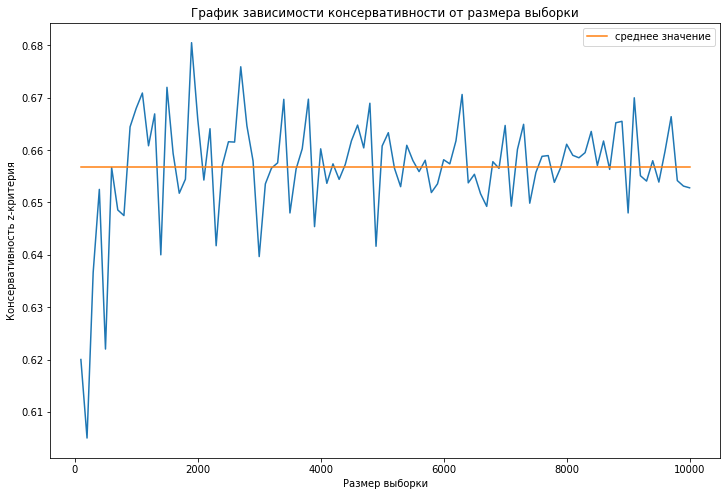

In [4]:
plt.figure(figsize = (12, 8))
plt.plot(size, result)
plt.plot((min(size), max(size)), (np.mean(result), np.mean(result)), label='среднее значение')
plt.title('График зависимости консервативности от размера выборки')
plt.xlabel('Размер выборки')
plt.ylabel('Консервативность z-критерия')
plt.legend()

Видим, что для достаточно больших выборок консервативность не зависит от их размера. Однако, также видно, что с ростом мощности выборки уменьшается дисперсия оценки консервативности.

2) Исследуем зависимость консервативности z-критерия для корреляции Пирсона от проверяемого значения коэффициента корреляции.

Для этого будем изменять $\sigma$ -- std нормального распределения, откуда мы сэмплируем. 

In [5]:
results_corr = []
sigmas = list(np.logspace(0.001, 1, 100) - 1)
corr_coefs = list(map(lambda sigma: 1 / np.sqrt(1 + sigma ** 2), sigmas))

for sigma in tqdm(sigmas):
    results_corr.append(test(1000, sample_size, sigma))

  0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in arctanh
  This is separate from the ipykernel package so we can avoid doing imports until


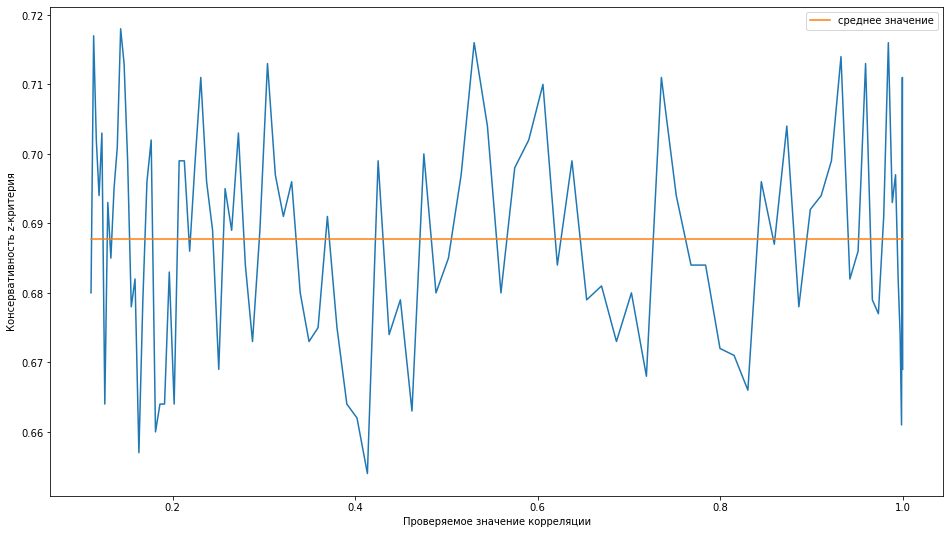

In [6]:
plt.figure(figsize = (16, 9))
plt.plot(corr_coefs, results_corr)
plt.plot((min(corr_coefs), max(corr_coefs)), (np.mean(results_corr), np.mean(results_corr)), label='среднее значение')
plt.xlabel('Проверяемое значение корреляции')
plt.ylabel('Консервативность z-критерия')
plt.legend()

Вывод :Явной зависимости не наблюдается, виден просто небольшой шум.